In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import import_ipynb
import Captcha_seg
import time

importing Jupyter notebook from Captcha_seg.ipynb


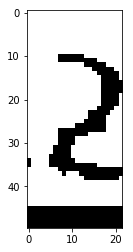

In [2]:
SEGMENTS_DIR = 'Segmented'
CAPTCHA_DIR = 'CAPTCHAs'
predictions = []
b_captcha = []

DATADIR = "./captcha_segmented/"
CATEGORIES= ["2","3","4","5","6","7","8","b","c","d","e","f","g","m","n","p","w","x","y"]
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        break
    break

In [3]:
print(img_array.shape)

(50, 22)


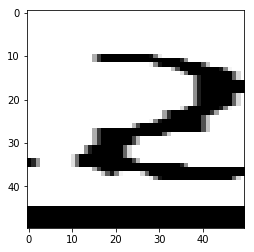

In [4]:
IMG_SIZE = 50

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap= 'gray')
plt.show()

In [5]:
train_data = []

def create_train_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category) 
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                train_data.append([new_array,class_num])
            except Exception as e:
                pass
            
create_train_data()

In [6]:
print(len(train_data))

3325


In [7]:
import random

random.shuffle(train_data)

In [8]:
for sample in train_data[:10]:
    print(sample[1])

9
7
8
1
9
10
5
4
16
16


In [9]:
X = []
y = []

In [10]:
for features, label in train_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [11]:
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()
pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [12]:
pickle_in= open("X.pickle", "rb")
X = pickle.load(pickle_in)
X.shape[1:]

(50, 50, 1)

In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, Flatten, Conv2D, MaxPooling2D

X = pickle.load(open("X.pickle","rb"))
y = pickle.load(open("y.pickle","rb"))

X = X/255.0

model = Sequential()

model.add(Conv2D(64,(3,3),input_shape= X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))


model.add(Dense(19))
model.add(Activation("softmax"))

from keras.utils import to_categorical
y_binary = to_categorical(y)

model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

model.fit(X,y_binary,batch_size=128, epochs=10, validation_split = 0.2)


Train on 2660 samples, validate on 665 samples
Epoch 1/10
2660/2660 [==============================] - 10s 4ms/step - loss: 2.7280 - acc: 0.1985 - val_loss: 2.1453 - val_acc: 0.3549
Epoch 2/10
2660/2660 [==============================] - 10s 4ms/step - loss: 1.3829 - acc: 0.5977 - val_loss: 1.0603 - val_acc: 0.7218
Epoch 3/10
2660/2660 [==============================] - 10s 4ms/step - loss: 0.7811 - acc: 0.7835 - val_loss: 0.7660 - val_acc: 0.8346
Epoch 4/10
2660/2660 [==============================] - 10s 4ms/step - loss: 0.5416 - acc: 0.8515 - val_loss: 0.6424 - val_acc: 0.8406
Epoch 5/10
2660/2660 [==============================] - 10s 4ms/step - loss: 0.4181 - acc: 0.8853 - val_loss: 0.5474 - val_acc: 0.8526
Epoch 6/10
2660/2660 [==============================] - 10s 4ms/step - loss: 0.3073 - acc: 0.9173 - val_loss: 0.4829 - val_acc: 0.8752
Epoch 7/10
2660/2660 [==============================] - 10s 4ms/step - loss: 0.2664 - acc: 0.9214 - val_loss: 0.4763 - val_acc: 0.8797
Epoch 8/

In [15]:
#model.summary()

In [17]:
def similarity(a,b):
    i =0
    for x,y in zip(a,b):
        if x==y:
            i+= 1
    percentage = (i/5) * 100
    return percentage

def prepare(filepath):
    IMG_SIZE = 50
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
    #plt.imshow(new_array,'gray')
    return new_array.reshape(-1, IMG_SIZE,IMG_SIZE,1)

total_time = 0
score = 0
count = 0
for captchas in os.listdir(CAPTCHA_DIR):
    start_time = time.time()
    predict_list= []
    captcha_name = captchas.split('.')
    print('\n')
    print('Actual: ',captcha_name[0])
    
    captcha_path =os.path.join(CAPTCHA_DIR,captchas)
    Captcha_seg.segment(captcha_path)
    
    files = []
    for segments in os.listdir(SEGMENTS_DIR):
        files.append(segments)
        files.sort()
    
    for segments in files:
        filepath = os.path.join(SEGMENTS_DIR,segments)
        prediction = model.predict([prepare(filepath)])
        predict_list.append(CATEGORIES[np.argmax(prediction[0])])
    
    elapsed_time = time.time()-start_time
    total_time += elapsed_time
    final_prediction = ''.join(predict_list)
    if captcha_name[0]== final_prediction:
        score +=1
    
    print('Predicted:',final_prediction,'\n')
    print('Percentage Similarity= ',similarity(captcha_name[0],final_prediction))
    print('Elapsed time= ',elapsed_time,'s')
    print('<------------------------------->')    
    predictions.append(similarity(captcha_name[0],final_prediction))
    count += 1


print('Total number of CAPTCHAS broken: ',score)    
print('Total number of CAPTCHAS attempted: ',count)
avg_prediction = score/count
print('Average Characters Predicted= ',avg_prediction,'%')
print('Total time taken= ',total_time,'s')
#model = tf.keras.models.load_model('captcha_alpha.model')
#prediction = model.predict([prepare('3.png')])
#print(len(prediction[0]))
#print(prediction[0])
#print(CATEGORIES[np.argmax(prediction[0])])



Actual:  ybfx6
Predicted: ybfx6 

Percentage Similarity=  100.0
Elapsed time=  0.019937992095947266 s
<------------------------------->


Actual:  nxc83
Predicted: cxc83 

Percentage Similarity=  80.0
Elapsed time=  0.0196683406829834 s
<------------------------------->


Actual:  p2m6n
Predicted: p7m6n 

Percentage Similarity=  80.0
Elapsed time=  0.02098870277404785 s
<------------------------------->


Actual:  ncyx8
Predicted: mcyx5 

Percentage Similarity=  60.0
Elapsed time=  0.01877140998840332 s
<------------------------------->


Actual:  gmmne
Predicted: gmmme 

Percentage Similarity=  80.0
Elapsed time=  0.020265579223632812 s
<------------------------------->


Actual:  md344
Predicted: md344 

Percentage Similarity=  100.0
Elapsed time=  0.017322301864624023 s
<------------------------------->


Actual:  y5dpp
Predicted: 45dpp 

Percentage Similarity=  80.0
Elapsed time=  0.01798272132873535 s
<------------------------------->


Actual:  x775w
Predicted: x775x 

Percenta

Predicted: f7577 

Percentage Similarity=  60.0
Elapsed time=  0.022507190704345703 s
<------------------------------->


Actual:  xmcym
Predicted: xmcym 

Percentage Similarity=  100.0
Elapsed time=  0.021160125732421875 s
<------------------------------->


Actual:  xf4p4
Predicted: xf4p4 

Percentage Similarity=  100.0
Elapsed time=  0.02317333221435547 s
<------------------------------->


Actual:  p4pde
Predicted: p4pce 

Percentage Similarity=  80.0
Elapsed time=  0.02288198471069336 s
<------------------------------->


Actual:  nwfde
Predicted: dxfce 

Percentage Similarity=  40.0
Elapsed time=  0.023098468780517578 s
<------------------------------->


Actual:  w46ep
Predicted: 646c2 

Percentage Similarity=  40.0
Elapsed time=  0.020879745483398438 s
<------------------------------->


Actual:  nnfx3
Predicted: mmfx3 

Percentage Similarity=  60.0
Elapsed time=  0.02181410789489746 s
<------------------------------->


Actual:  nny5e
Predicted: mny5e 

Percentage Similarity= 

Predicted: m7neb 

Percentage Similarity=  60.0
Elapsed time=  0.023529052734375 s
<------------------------------->


Actual:  yw7ny
Predicted: xx27y 

Percentage Similarity=  20.0
Elapsed time=  0.02195286750793457 s
<------------------------------->


Actual:  feyc8
Predicted: feyc5 

Percentage Similarity=  80.0
Elapsed time=  0.02278423309326172 s
<------------------------------->


Actual:  pdw38
Predicted: pcy78 

Percentage Similarity=  40.0
Elapsed time=  0.023697614669799805 s
<------------------------------->


Actual:  x7422
Predicted: x7472 

Percentage Similarity=  80.0
Elapsed time=  0.021703243255615234 s
<------------------------------->


Actual:  f85y3
Predicted: 78573 

Percentage Similarity=  60.0
Elapsed time=  0.021625280380249023 s
<------------------------------->


Actual:  xxney
Predicted: xx7cy 

Percentage Similarity=  60.0
Elapsed time=  0.022220611572265625 s
<------------------------------->


Actual:  pmg55
Predicted: pmg55 

Percentage Similarity=  100

Predicted: n3bm6 

Percentage Similarity=  100.0
Elapsed time=  0.025084733963012695 s
<------------------------------->


Actual:  gewfy
Predicted: gex7y 

Percentage Similarity=  60.0
Elapsed time=  0.02292180061340332 s
<------------------------------->


Actual:  yd38e
Predicted: yc38e 

Percentage Similarity=  80.0
Elapsed time=  0.0217897891998291 s
<------------------------------->


Actual:  nw5b2
Predicted: my742 

Percentage Similarity=  20.0
Elapsed time=  0.022489547729492188 s
<------------------------------->


Actual:  mddgb
Predicted: mdcgb 

Percentage Similarity=  80.0
Elapsed time=  0.022070646286010742 s
<------------------------------->


Actual:  fwxdp
Predicted: fxccn 

Percentage Similarity=  20.0
Elapsed time=  0.024286746978759766 s
<------------------------------->


Actual:  x2cnn
Predicted: x7cnn 

Percentage Similarity=  80.0
Elapsed time=  0.023195505142211914 s
<------------------------------->


Actual:  geyn5
Predicted: geym5 

Percentage Similarity=  

Predicted: m6nc5 

Percentage Similarity=  20.0
Elapsed time=  0.02207636833190918 s
<------------------------------->


Actual:  nfbg8
Predicted: mf6g8 

Percentage Similarity=  60.0
Elapsed time=  0.032649993896484375 s
<------------------------------->


Actual:  nfcwy
Predicted: mfc6x 

Percentage Similarity=  40.0
Elapsed time=  0.024419069290161133 s
<------------------------------->


Actual:  nxn4f
Predicted: mxn47 

Percentage Similarity=  60.0
Elapsed time=  0.024723291397094727 s
<------------------------------->


Actual:  pdcp4
Predicted: cdcp4 

Percentage Similarity=  80.0
Elapsed time=  0.0239865779876709 s
<------------------------------->


Actual:  yyg5g
Predicted: yyc5g 

Percentage Similarity=  80.0
Elapsed time=  0.022475242614746094 s
<------------------------------->


Actual:  gpnxn
Predicted: g2mxn 

Percentage Similarity=  60.0
Elapsed time=  0.021764278411865234 s
<------------------------------->


Actual:  n3m6x
Predicted: m3m6y 

Percentage Similarity=  6

Predicted: y2ye8 

Percentage Similarity=  100.0
Elapsed time=  0.02624654769897461 s
<------------------------------->


Actual:  pwn5e
Predicted: px4x3 

Percentage Similarity=  20.0
Elapsed time=  0.02228569984436035 s
<------------------------------->


Actual:  x37bf
Predicted: x37bf 

Percentage Similarity=  100.0
Elapsed time=  0.02222299575805664 s
<------------------------------->


Actual:  xp24p
Predicted: xp24c 

Percentage Similarity=  80.0
Elapsed time=  0.02232956886291504 s
<------------------------------->


Actual:  mgw3n
Predicted: mc43m 

Percentage Similarity=  40.0
Elapsed time=  0.022106647491455078 s
<------------------------------->


Actual:  ncww7
Predicted: mcxx7 

Percentage Similarity=  40.0
Elapsed time=  0.02279829978942871 s
<------------------------------->


Actual:  ydd3g
Predicted: ycc3c 

Percentage Similarity=  40.0
Elapsed time=  0.024506092071533203 s
<------------------------------->


Actual:  n8fp6
Predicted: m67p6 

Percentage Similarity=  4

Predicted: fyxb2 

Percentage Similarity=  60.0
Elapsed time=  0.023361921310424805 s
<------------------------------->


Actual:  neecd
Predicted: meec7 

Percentage Similarity=  60.0
Elapsed time=  0.022949934005737305 s
<------------------------------->


Actual:  nmy2x
Predicted: cmx2c 

Percentage Similarity=  40.0
Elapsed time=  0.02635812759399414 s
<------------------------------->


Actual:  mcyfx
Predicted: mcy7x 

Percentage Similarity=  80.0
Elapsed time=  0.023499488830566406 s
<------------------------------->


Actual:  x347n
Predicted: x347n 

Percentage Similarity=  100.0
Elapsed time=  0.025018692016601562 s
<------------------------------->


Actual:  yyn57
Predicted: yym57 

Percentage Similarity=  80.0
Elapsed time=  0.02235722541809082 s
<------------------------------->


Actual:  p2ym2
Predicted: c2ym2 

Percentage Similarity=  80.0
Elapsed time=  0.023290395736694336 s
<------------------------------->


Actual:  g247w
Predicted: g247x 

Percentage Similarity= 

Predicted: gcfgp 

Percentage Similarity=  100.0
Elapsed time=  0.03823208808898926 s
<------------------------------->


Actual:  nwg2m
Predicted: myc6m 

Percentage Similarity=  20.0
Elapsed time=  0.04477405548095703 s
<------------------------------->


Actual:  f5e5e
Predicted: f5e5e 

Percentage Similarity=  100.0
Elapsed time=  0.040950775146484375 s
<------------------------------->


Actual:  p7fyp
Predicted: c7fyp 

Percentage Similarity=  80.0
Elapsed time=  0.04332923889160156 s
<------------------------------->


Actual:  xc68n
Predicted: 3c68m 

Percentage Similarity=  60.0
Elapsed time=  0.03827500343322754 s
<------------------------------->


Actual:  men4f
Predicted: mx5xf 

Percentage Similarity=  40.0
Elapsed time=  0.041674137115478516 s
<------------------------------->


Actual:  my84e
Predicted: mn754 

Percentage Similarity=  20.0
Elapsed time=  0.040070295333862305 s
<------------------------------->


Actual:  fpw76
Predicted: fpx76 

Percentage Similarity=  